# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
# !pip install wandb
!pip3 install pytorch_lightning torchmetrics

In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

In [1]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import PIL
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# You may add any imports you need

In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [4]:
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# Использовал автоаугментацию для ImageNet
train_transform = transforms.Compose([
      transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)
val_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

train_dataset = ImageFolder('../input/iad-hw2-2022/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('../input/iad-hw2-2022/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=1
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=1
)

In [43]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

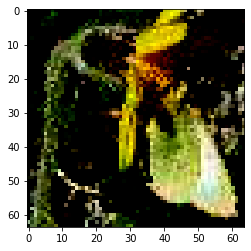

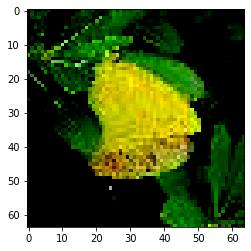

In [17]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [5]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 4 * 512, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.output = nn.Linear(500, 200)


    def _forward(self, x):   
        x = self.block1(x)
        x = self.dropout(x)
        x = self.block2(x)
        x = self.dropout(x)
        x = self.block3(x)
        x = self.dropout(x)
        x = self.block4(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        return self.output(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss

    def get_accuracy(self, reset=True):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        
        return self.accuracy

### Тренировочный класс lightning

In [6]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)  # сохраняет логи в папку, но можно несложно добавить wandb

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        accuracy = self.model.get_accuracy()
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", accuracy, prog_bar=True)
        
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        # Сохранение весов и оптимайзера
        torch.save({
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            }, "weights")

In [20]:
model1 = YourNet().to(device)
module1 = YourModule(
    model1,
    learning_rate=0.001
)

In [21]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=80
)
trainer.fit(module1, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Валидация результатов задания

In [7]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model._forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [8]:
checkpoint1 = torch.load("../input/best-models/weights") # kaggle
model1_val = YourNet()
model1_val.load_state_dict(checkpoint1['model_state_dict'])

accuracy1 = evaluate_task(model1_val, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy1 / 0.44, 0, 10):.2f} баллов")

100%|██████████| 20/20 [00:44<00:00,  2.25s/it]

Оценка за это задание составит 9.74 баллов


In [9]:
print(f"Количество эпох: {checkpoint1['epoch']}")
print(f"Accuracy: {accuracy1}")
print(f"Loss: {checkpoint1['loss']}")

Количество эпох: 53
Accuracy: 0.4284
Loss: 2.58886981010437


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [15]:
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# Использовал автоаугментацию для ImageNet
train_transform2 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)
val_transform2 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

train_dataset2 = ImageFolder('../input/iad-hw2-2022/dataset/dataset/train', transform=train_transform2)
val_dataset2 = ImageFolder('../input/iad-hw2-2022/dataset/dataset/val', transform=val_transform2)

train_dataloader2 = DataLoader(
    train_dataset2,
    batch_size=128,
    shuffle=True,
    num_workers=1
)
val_dataloader2 = DataLoader(
    val_dataset2,
    batch_size=128,
    shuffle=False,
    num_workers=1
)

In [10]:
from torchvision.models import resnet50

In [11]:
class YourNet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
        
        self.model = resnet50(pretrained=True)
        self.model.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 200)
        )

    def _forward(self, x):
        x = self.model(x)
        
        return self.classifier(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss

    def get_accuracy(self, reset=True):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        
        return self.accuracy

### Тренировочный класс lightning

In [12]:
class YourModule2(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.accuracy_history = []
        self.loss_history = []
        
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)  # сохраняет логи в папку, но можно несложно добавить wandb

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        accuracy = self.model.get_accuracy()
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", accuracy, prog_bar=True)
        self.accuracy_history.append(accuracy.item())
        self.loss_history.append(loss.item())
        
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        # Сохранение весов и оптимайзера
        torch.save({
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            }, "weights2")

In [10]:
model2 = YourNet2().to(device)
module2 = YourModule2(
    model=model2,
    learning_rate=0.0001
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
trainer2 = pl.Trainer(
    accelerator="gpu",
    max_epochs=100
)
trainer2.fit(module2, train_dataloader2, val_dataloader2)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Валидация результатов задания

In [12]:
model2_val = model2

accuracy2 = evaluate_task(model2_val, val_dataloader2)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy2 - 0.5) / 0.34, 0, 10):.2f} баллов")


100%|██████████| 79/79 [00:30<00:00,  2.60it/s]

Оценка за это задание составит 7.18 баллов


In [13]:
accuracy2

0.7441

In [16]:
# Эта модель зафиксирована, так что лучше считать оценку по ней (веса от модели выше я потерял)
checkpoint2 = torch.load("../input/best-models/weights2") # kaggle
model2_val = YourNet2()
model2_val.load_state_dict(checkpoint2['model_state_dict'])

accuracy2 = evaluate_task(model2_val, val_dataloader2)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy2 - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 79/79 [00:32<00:00,  2.46it/s]

Оценка за это задание составит 7.08 баллов


In [17]:
accuracy2

0.7408

# Отчёт об экспериментах 

# Задание 1

Графики не сохранились, так как я поздно об этом вспомнил. Вместо этого опишу словами, что делал.

Сначала пытался учить модель с использованием маленького батча (32), но понял, что это плохая идея, так как обучение шло слишком долго, поэтому батч поменял на 1024 и получил нехватку видеопамяти. После этого взял батч равный 512 и проблем больше не было.

В качестве первой модели попытался сделать некоторое подобие vgg: написал 2 vgg-блока, в каждом из которых были 2 свёртки, а также батч-нормализации и релу за ними. Перед выходами был MaxPooling(2, stride=2). Во всех последующих моделях конфигурация пулинга была такой. Её я подсмотрел, кажется, в одной из реализаций vgg (здесь, если не ошибаюсь - https://blog.paperspace.com/vgg-from-scratch-pytorch/). Как я понял, это самая распространённая конфигурация. На выходе всегда стояли 3 линейных слоя, они имели выходы 1000, 500 и 200. Данная модель с батчем 32 обучалась очень долго и за несколько эпох дала долю верных предсказаний около процента (примерно за 4 эпохи), а потом вылетела.

Во второй модели я использовал батч-сайз 1024. Также я изменил модель, сделав её больше похожей на vgg. В этот раз использовал 4 блока. Количество выходных каналов - это просто степени 2: 32, 64, 256 и 512. Ядро всегда брал равным 3, а паддинг равный 1 компенсировал уменьшение картинки. Из-за пуллинга картинка каждый раз уменьшалась в 2 раза. Изначальный размер - 64x64, затем 32x32, 16x16, 8x8 и 4x4. 4 * 4 * 512 - количество входных каналов первого полносвязного слоя. Эта модель спустя 17 эпох показала качество 0.21, а затем kaggle вылетел из-за нехватки видеопамяти.

В итоговой третьей модели я добавил аугментации, которые использовались на датасете ImageNet, а также dropout = 0.16 после каждого блока, а также между полносвязными слоями. Также уменьшил батч до 512. Данная модель спустя примерно 53 эпохи дала результат около 0.42. Я сохранил веса на 53 эпохе и продолжил наблюдать, но веса спустя 10 или 15 эпох выше не поднялись, так что я зафиксировал эту модель как лучшую.

# Задание 2

**resnet18, 6 эпох, accuracy = 0.59, batch_size = 256**

In [ ]:
# Использованные аугментации:
# transforms.Resize((224, 224)),
# transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
# transforms.ToTensor(),
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

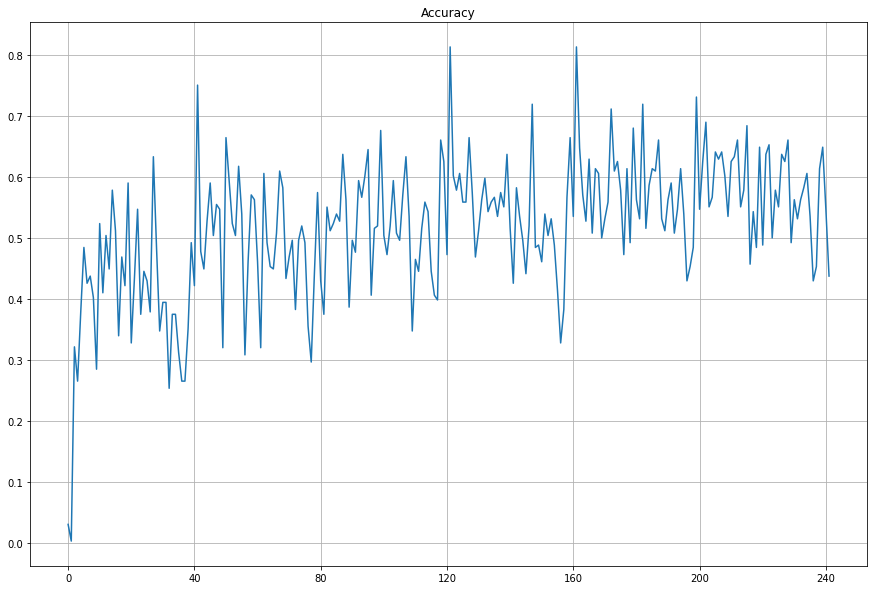

In [38]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.accuracy_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Accuracy")
plt.show()
# На графике показана accuracy на валидационных батчах, каждые 40 батчей эпоха сменяется
# Можно заметить, что accuracy застряла примерно на уровне 0.5 - 0.6
# Скорее всего это потолок для данной модели

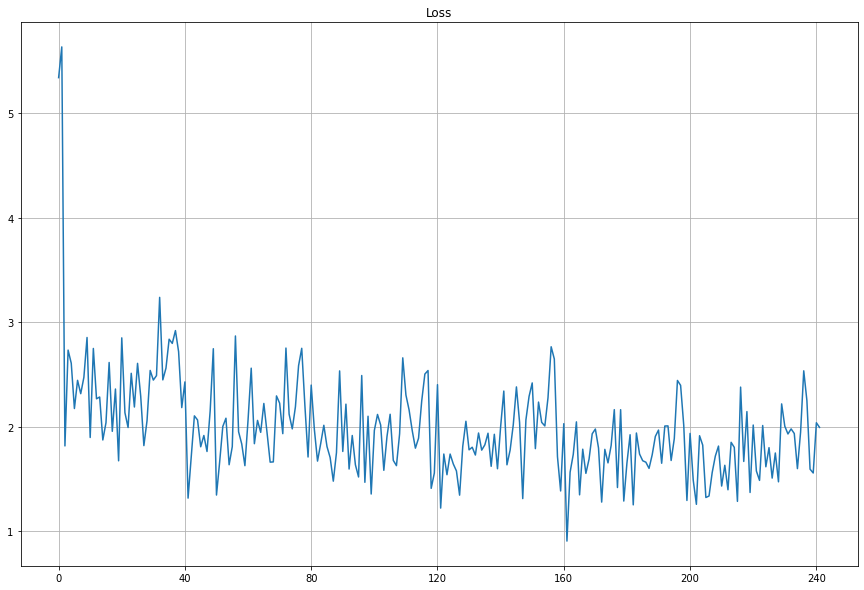

In [39]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.loss_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Loss")
plt.show()
# loss около 2, но дальше не идёт

In [ ]:
# Использованные аугментации:
# transforms.Resize((224, 224)),
# transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
# transforms.RandomHorizontalFlip(p=0.5),
# transforms.ToTensor(),
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

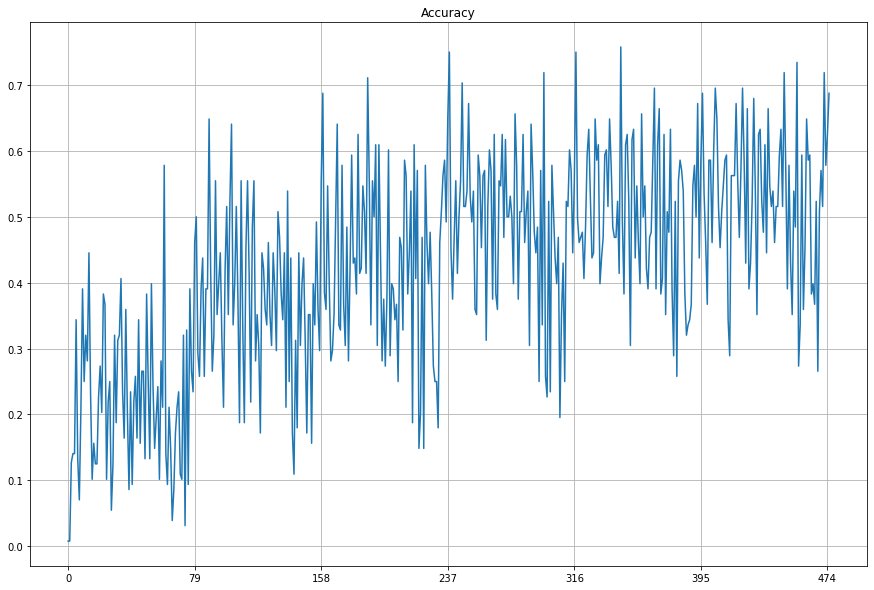

In [23]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.accuracy_history)
plt.grid(True)
plt.xticks([0, 79, 158, 237, 316, 395, 474])
plt.title("Accuracy")
plt.show()
# batch-size изменил на 128
# На графике показана accuracy на валидационных батчах, каждые 79 батчей эпоха сменяется
# Можно заметить, что accuracy застряла примерно на уровне 0.5 - 0.6
# Скорее всего это потолок для данной модели

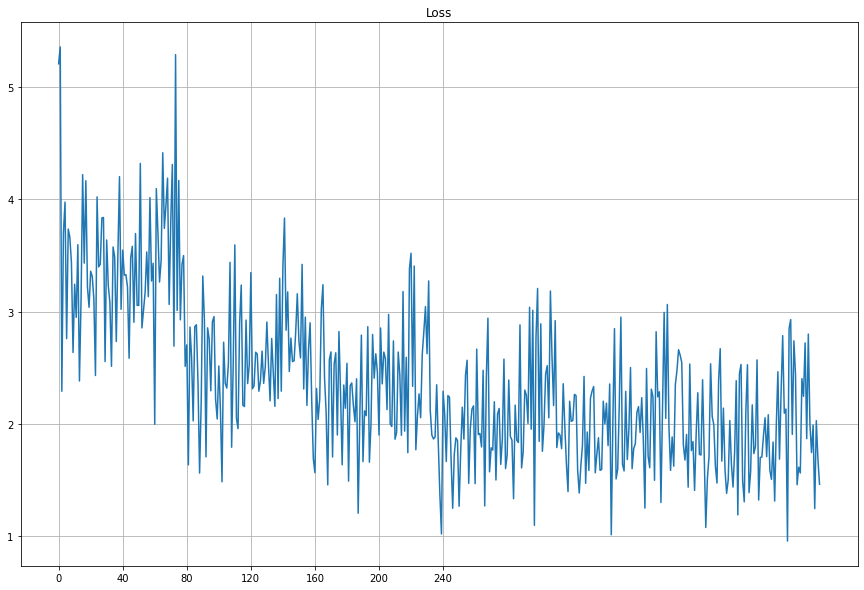

In [21]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.loss_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Loss")
plt.show()
# loss около 2, возможно стал бы ещё ниже

Дальше я параллельно тестировал 2 модели: в colab'е и в kaggl'е.

In [ ]:
# Для обеих моделей я изменил выходной слой следующим образом
# self.classifier = nn.Sequential(
#             nn.Linear(2048, 500),
#             nn.ReLU(),
#             nn.Dropout(p=0.16),
#             nn.Linear(500, 200)
#         )

# Также заменил аугментации (убрал автоаугментацию для ImageNet)
# transforms.Resize((224, 224)),
# transforms.RandomHorizontalFlip(p=0.5),
# transforms.ToTensor(),
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

В colab я использовал предобученную **resnet50 с batch-size = 128 и шагом 0.0005**. После 7 эпох доля верных ответов оказалась равна 0.6. Данная модель не стоит внимания, так как следующая (которая училась параллельно) оказалась лучше.

В kaggle я обучал **resnet18 с batch-size=256 и шагом 0.0003.** Псоле 8 эпох я закончил обучение и получил итоговое accuracy = 0.65. На графике также видно, что доля правильных ответов вышла на плато и выше она бы не поднялась. Но самым важным было то, что loss на трейне был около 0.2, а на тесте - 1.6. Это значит, что модель переобучилась и дальше нужно бороться именно с этим. Также кажется, что чем меньше шаг, тем лучше качество (судя по этой и предыдущей моделям).

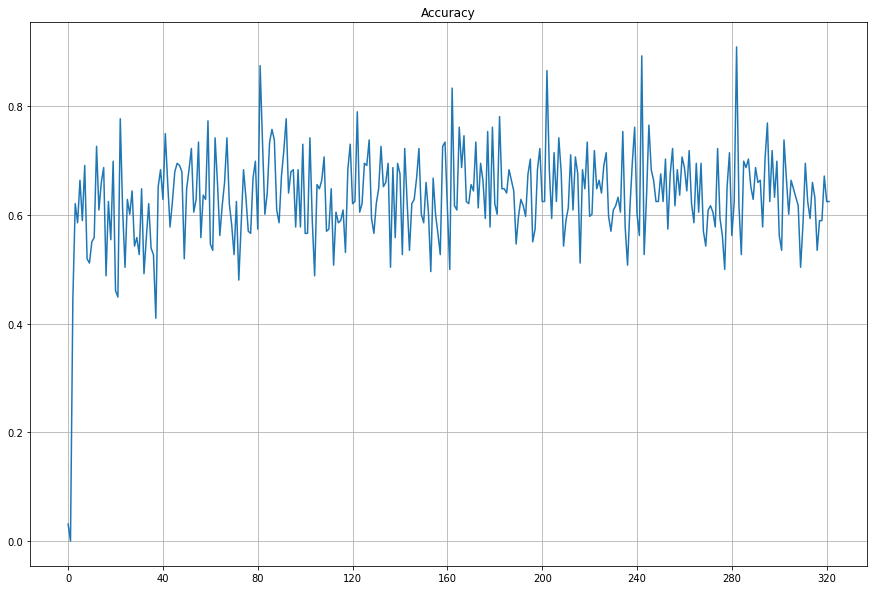

In [21]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.accuracy_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240, 280, 320])
plt.title("Accuracy")
plt.show()

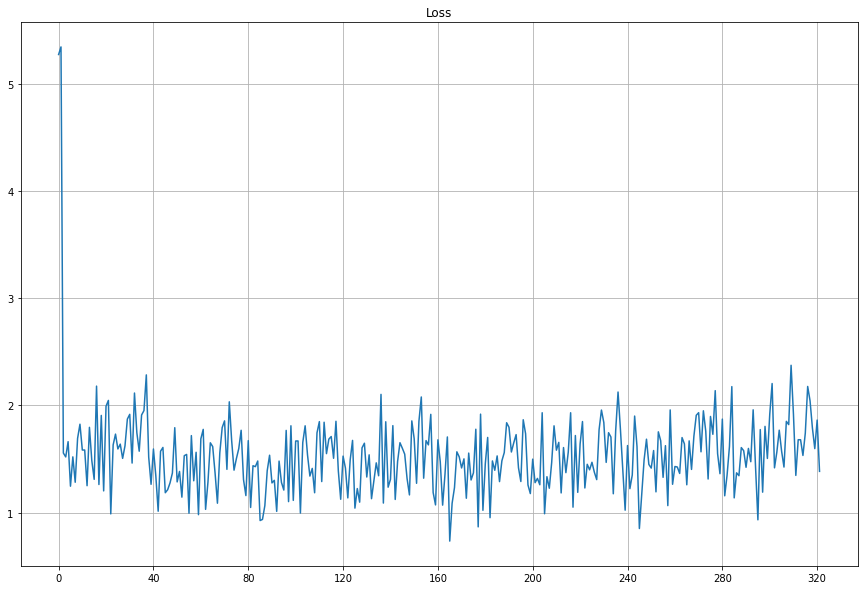

In [22]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.loss_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240, 280, 320])
plt.title("Loss")
plt.show()

В следующей модели установил шаг 0.0001. После 8 эпох accuracy стал равен 0.6717. В этой модели получилось опустить loss ниже 1.6, он стал равен 1.4.

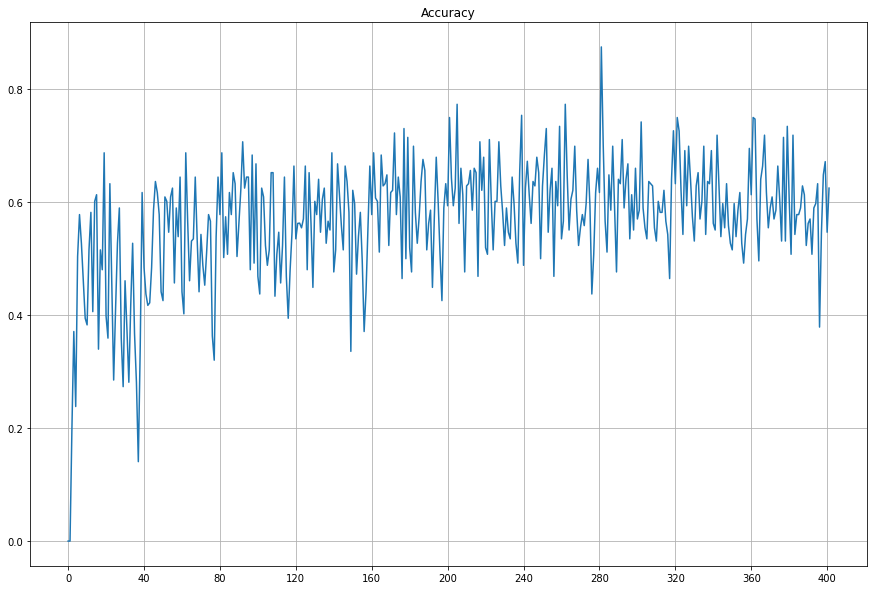

In [36]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.accuracy_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400])
plt.title("Accuracy")
plt.show()

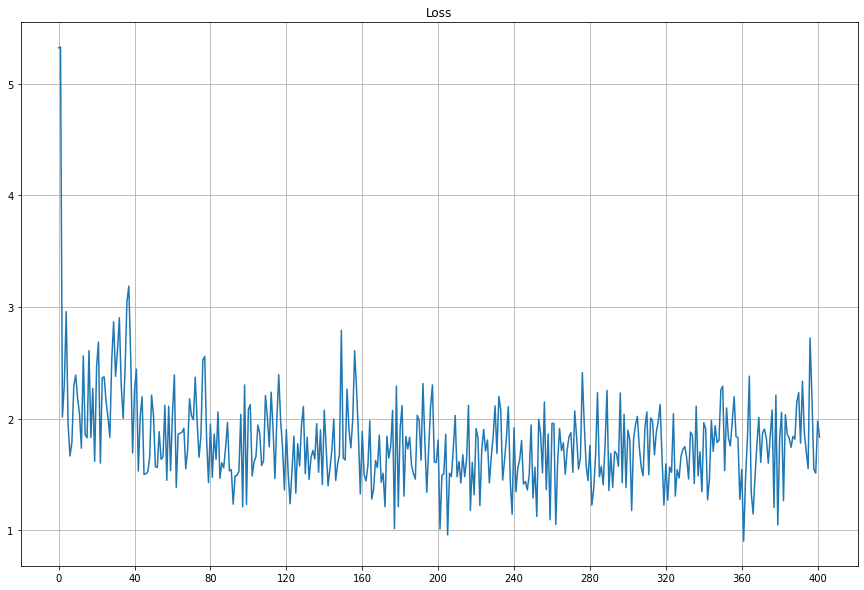

In [37]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.loss_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400])
plt.title("Loss")
plt.show()

https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ - здесь прочитал, что BatchNorm и Dropout лучше не использовать в одной сетке, поэтому я оставил только BatchNorm. Качество оказалось 0.649, а loss - около 1.4

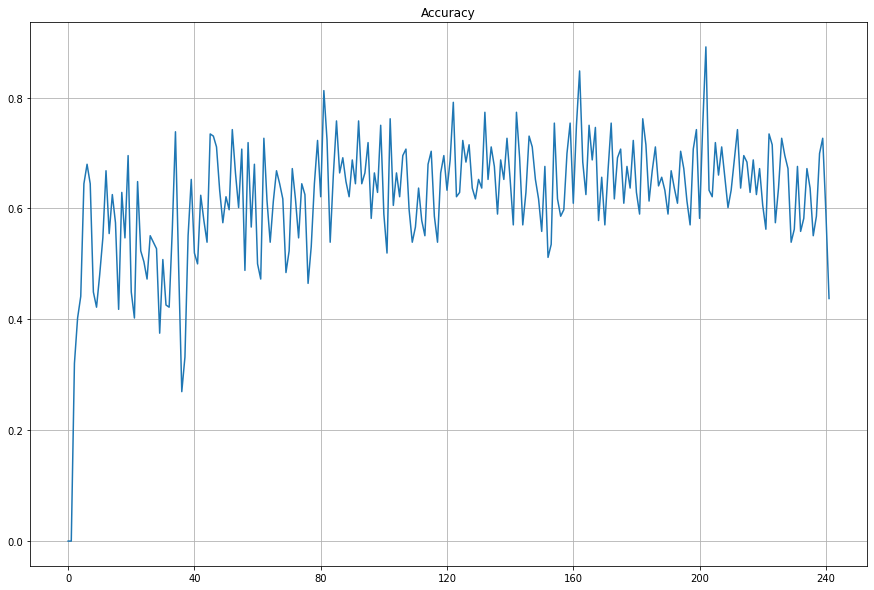

In [50]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.accuracy_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Accuracy")
plt.show()

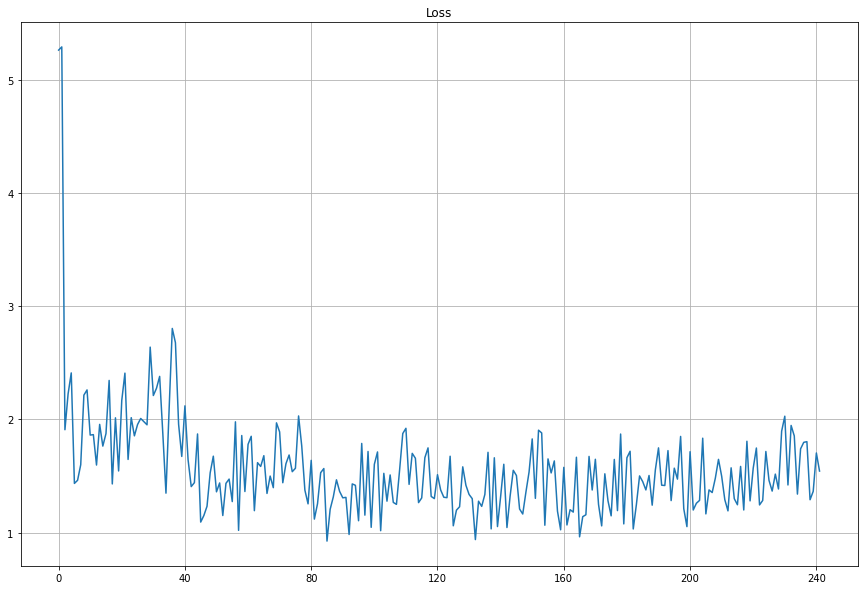

In [53]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.loss_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Loss")
plt.show()

Следующая модель - это resnet50 с батчём 128. loss на тесте около 1, accuracy = 0.74. Лучшая модель.

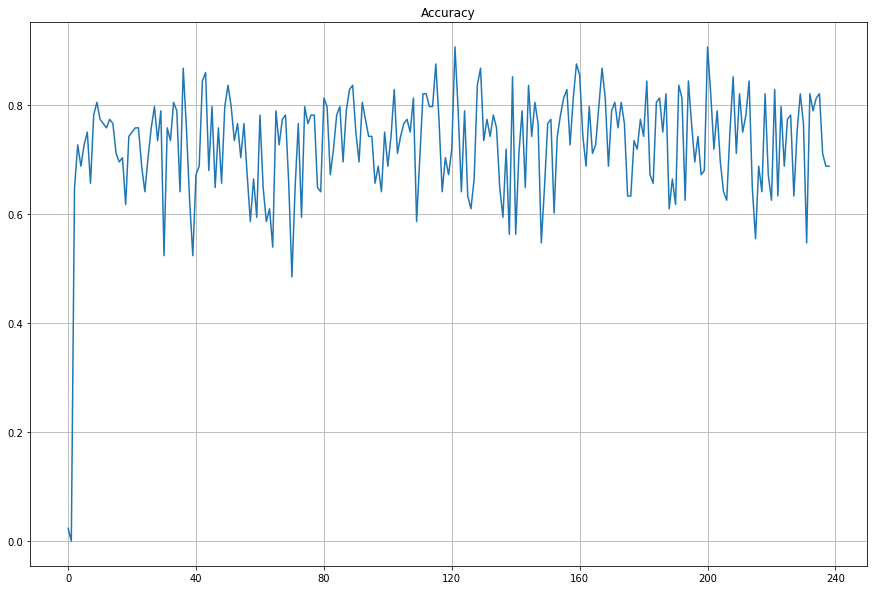

In [14]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.accuracy_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Accuracy")
plt.show()

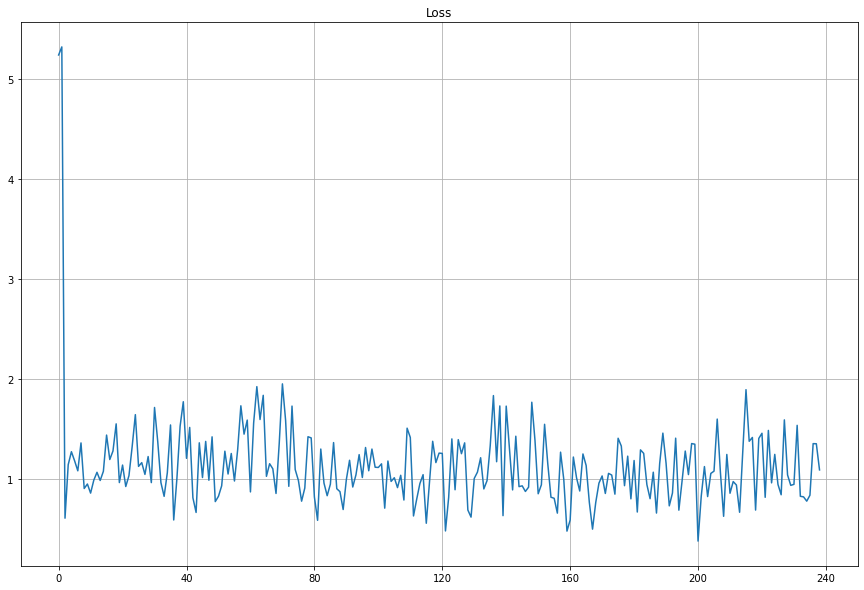

In [15]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=module2.loss_history)
plt.grid(True)
plt.xticks([0, 40, 80, 120, 160, 200, 240])
plt.title("Loss")
plt.show()